In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.express as px 
import seaborn as sns
import re
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from collections import Counter

from scipy.stats import kruskal
from scipy.stats import f_oneway

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In this notebook we have a look at [`winemag-data-130k-v2.csv`](https://www.kaggle.com/datasets/zynicide/wine-reviews)] which contain data about general information about wine. `winemag-data-130k-v2.csv` has 129971 entries and 14 columns.

Considering the data contained in this dataset as well as the problem to be solved, our study could have two goals: (1) identify the factors that drive the price of wine and (2) identify what influence the ratings of wine. For this, we would consider the following columns:
* `id`: Unique identification of the wine.
* `country`: The country that the wine is from.
* `points`: The number of points WineEnthusiast rated the wine on a scale of 1-100.
* `price`: The cost for a bottle of the wine.
* `province`: The province or state that the wine is from.
* `region_1`: The wine growing area in a province or state.
* `title`: The title of the wine review.
* `variety`: The type of grapes used to make the wine.
* `winery`: The winery that made the wine.

Findings:
* Wine from certain countries are more expensive than others. On average, the most expensive wines comes from Europe and North America, followed by Oceania and the Middle East.
* The most expensive wine bottle cost \\$3300 while the cheapest is \\$4.
* There is a strong monotonic relationship between `price` and `points`. The higher the rating, the higher the price.
* Country is associated with the price of wine as well as the wine customer ratings. Some countries produces on average more expensive and/or higher rated wine than others.
* Some variety of wine tend are associated with higher prices and/or ratings compared to others. The highest rated and most expensive wine variety is Nebbiolo.
* Similarly, certain wineries produces wine sold for different prices and receive different ratings.
* When it comes to price, the difference depending on the factors mentionned earlier is quite significant.
* When it comes to ratings (points), the wine ratings range is from 80 to 100 in the dataset.

In [2]:
def map_country_to_region(country):
    with open("country_region.json") as f:
        wine_regions = json.load(f)    
        return wine_regions.get(country, 'Region not found')

## Import data

In [3]:
winemag = pd.read_csv("dataset/winemag-data-130k-v2.csv")
winemag.shape

(129971, 14)

## Winemag

In [4]:
winemag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [5]:
winemag_columns = ["id", "country", "points", "price", "province", "region_1", "title", "description", "variety", "winery"]

In [6]:
winemag_clean = winemag[winemag_columns]
winemag_clean.shape

(129971, 10)

In [7]:
winemag_clean.isnull().sum()

id                 0
country           63
points             0
price           8996
province          63
region_1       21247
title              0
description        0
variety            1
winery             0
dtype: int64

We remove entries with no `country` or `price`

In [8]:
winemag_clean = winemag_clean[(~winemag_clean["country"].isnull()) & (~winemag_clean["price"].isnull())]
winemag_clean.shape

(120916, 10)

Only one entry doesn't have a `variety`

In [9]:
winemag_clean = winemag_clean[~winemag_clean["variety"].isnull()]

Handle duplicates

In [10]:
print(f'We have {winemag_clean.drop("id", axis=1).duplicated().sum()} duplicates')

We have 9378 duplicates


In [11]:
winemag_clean = winemag_clean.drop("id", axis=1).drop_duplicates()

In [12]:
print(f"{winemag_clean.duplicated(subset=['title'], keep=False).sum()} wine titles are duplicated")

1729 wine titles are duplicated


In [13]:
winemag_clean[winemag_clean.duplicated(subset=['title'], keep=False)].sort_values(by="title").head(10)

,country,points,price,province,region_1,title,description,variety,winery
55163,Spain,87,16.0,Catalonia,Cava,1+1=3 NV Brut Sparkling (Cava),Spiced apple and toast aromas are clean and di...,Sparkling Blend,1+1=3
93375,Spain,87,16.0,Catalonia,Cava,1+1=3 NV Brut Sparkling (Cava),Dusty notes of citrus fruits are mild but frie...,Sparkling Blend,1+1=3
36820,France,89,49.0,Champagne,Champagne,A.R. Lenoble NV Dosage Zéro Brut Nature (Cha...,"Bone dry and crisp, this is also has fruitines...",Champagne Blend,A.R. Lenoble
115461,France,90,49.0,Champagne,Champagne,A.R. Lenoble NV Dosage Zéro Brut Nature (Cha...,"With zero grams of residual sugar, this is win...",Champagne Blend,A.R. Lenoble
38053,France,90,49.0,Champagne,Champagne,A.R. Lenoble NV Dosage Zéro Brut Nature (Cha...,This tight crisp wine delivers citrus and slic...,Champagne Blend,A.R. Lenoble
62767,France,91,54.0,Champagne,Champagne,A.R. Lenoble NV Grand Cru Blanc de Blancs Cho...,This is a very lively wine with a creamy mouss...,Chardonnay,A.R. Lenoble
58493,France,92,54.0,Champagne,Champagne,A.R. Lenoble NV Grand Cru Blanc de Blancs Cho...,The wine comes from the Grand Cru village of C...,Chardonnay,A.R. Lenoble
38054,France,90,45.0,Champagne,Champagne,A.R. Lenoble NV Intense Brut (Champagne),A quarter of this nonvintage blend was vinifie...,Champagne Blend,A.R. Lenoble
70823,France,89,45.0,Champagne,Champagne,A.R. Lenoble NV Intense Brut (Champagne),"With vineyards in the Marne Valley, this Champ...",Champagne Blend,A.R. Lenoble
88320,France,90,45.0,Champagne,Champagne,A.R. Lenoble NV Intense Brut (Champagne),Intense is a good description of this tightly ...,Champagne Blend,A.R. Lenoble


We observe that when wines have the same title/name, the difference lies in the `price`, `points`, and the `variety`. We remove duplicates using the following method:
1. If the difference lies in the `price` and/or `points`, we average these values.
2. If the difference is in the `variety`, then we keep them.

In [14]:
def remove_duplicated_titles(df):
    duplicates = df[df["title"].duplicated(keep=False)].copy()
    uniques = df.drop_duplicates(subset="title", keep=False).copy()
    
    duplicates["price"] = np.round(duplicates.apply(lambda x: duplicates.loc[(duplicates["title"] == x["title"]) & (duplicates["variety"] == x["variety"]), "price"].mean(), axis=1), 2)
    duplicates["points"] = np.round(duplicates.apply(lambda x: duplicates.loc[(duplicates["title"] == x["title"]) & (duplicates["variety"] == x["variety"]), "points"].mean(), axis=1), 0).astype(int)
    
    df = pd.concat([uniques, duplicates])
    df.sort_index()
    
    df = df.drop_duplicates()
    
    return df

In [15]:
winemag_clean = remove_duplicated_titles(winemag_clean)

In [16]:
winemag_clean.duplicated(subset=["title", "variety"]).sum()

793

### `price`

Observations:
* 99.4% of wines cost \\$200 or less and half of the wines in the dataset cost less than \\$25.
* When categorized the distribution of wine prices follows a normal distribution. Wine with moderate prices (\\$20-\\$50) are most numerous, followed by affordable (\\$10-\\$20) wines then expensive (\\$50-\\$200).

In [17]:
winemag_clean["price"].isnull().sum()

0

In [18]:
winemag_clean["price"].describe()[["min", "mean", "max", "std"]]

min        4.000000
mean      35.626276
max     3300.000000
std       42.109169
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Count'>

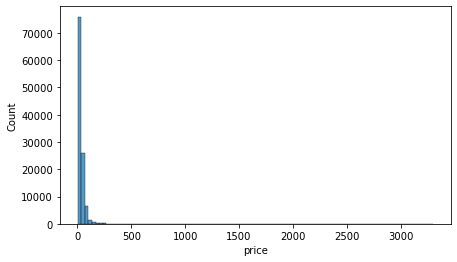

In [19]:
plt.figure(figsize=(7,4))
sns.histplot(data=winemag_clean, x="price", bins=100, color='tab:blue')

In [20]:
def indentify_outliers(arr):
    q1 = np.percentile(arr, 25)
    q3 = np.percentile(arr, 75)
    
    iqr = q3 - q1
    threshold = 1.5

    outliers = arr[(arr < q1 - threshold * iqr) | (arr > q3 + threshold * iqr)]
    
    return outliers

In [21]:
price_outliers = indentify_outliers(winemag_clean["price"].values)

In [22]:
np.min(price_outliers), np.max(price_outliers)

(80.0, 3300.0)

In [23]:
print(f'{np.round((winemag_clean["price"] <= 200).sum() / winemag_clean.shape[0] * 100, 2)}% of wine bottles cost $200 or less')
print(f'{np.round((winemag_clean["price"] >= 80).sum() / winemag_clean.shape[0] * 100, 2)}% of wine bottles cost over $80')
print(f'{np.round((winemag_clean["price"] < 80).sum() / winemag_clean.shape[0] * 100, 2)}% of wine bottles cost less than $80')
print(f'{np.round((winemag_clean["price"] <= 25).sum() / winemag_clean.shape[0] * 100, 2)}% of wine bottles cost $25 or less')

99.4% of wine bottles cost $200 or less
6.15% of wine bottles cost over $80
93.85% of wine bottles cost less than $80
50.55% of wine bottles cost $25 or less


In [24]:
winemag_clean = winemag_clean[winemag_clean["price"] < 80]

<AxesSubplot:xlabel='price'>

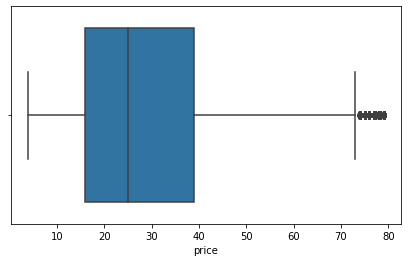

In [25]:
plt.figure(figsize=(7,4))
sns.boxplot(data=winemag_clean[winemag_clean["price"] < 80], x="price", color='tab:blue')

Let's categorize prices

In [26]:
def categorize_wine_price(price):
    if price < 0:
        raise Error("Negative price")
    
    if price <= 10:
        return "0-10"
    elif price < 20:
        return "11-20"
    elif price < 50:
        return "21-50"
    else:
        return "50+"

In [27]:
winemag_clean["price_group"] = winemag_clean["price"].apply(categorize_wine_price)

In [28]:
price_cat_order = ["0-10", "11-20", "21-50", "50+"]
winemag_clean["price_group"] = pd.Categorical(winemag_clean['price_group'], categories=price_cat_order, ordered=True)

<AxesSubplot:xlabel='price_group', ylabel='Count'>

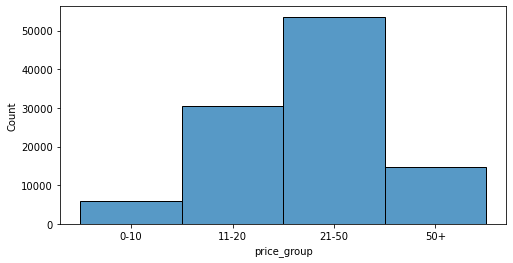

In [29]:
plt.figure(figsize=(8,4))
sns.histplot(data=winemag_clean.sort_values(by="price_group"), x="price_group", color='tab:blue')

### `points`

Observations:
* Most wines have a good rating of at least 80/100.
* The higher the rating, the higher the price. There is a strong monotonic relationship between `price` and `points`.

**Conclusion:** `points` is correlated to `price`.

In [30]:
winemag_clean["points"].isnull().sum()

0

In [31]:
winemag_clean["points"].describe()[["min", "max"]]

min    80.0
max    99.0
Name: points, dtype: float64

<AxesSubplot:xlabel='points'>

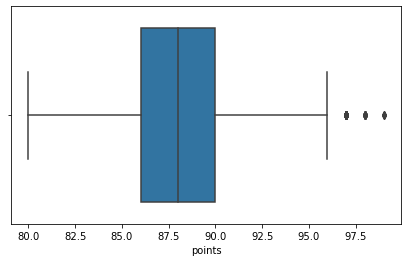

In [32]:
plt.figure(figsize=(7,4))
sns.boxplot(data=winemag_clean, x="points", color='tab:blue')

<AxesSubplot:xlabel='points', ylabel='Count'>

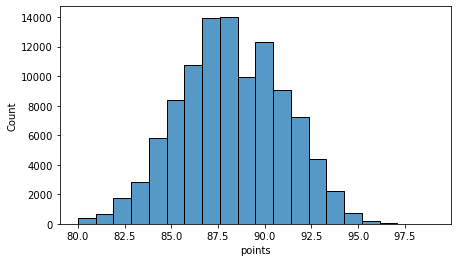

In [33]:
plt.figure(figsize=(7,4))
sns.histplot(data=winemag_clean, x="points", bins=20, color='tab:blue')

#### Relationship between `price` and `points`

<AxesSubplot:xlabel='price', ylabel='points'>

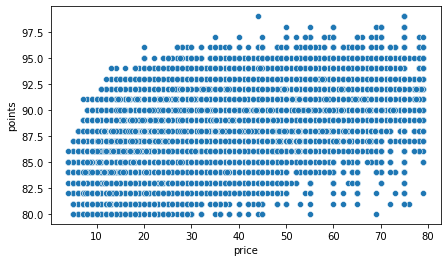

In [34]:
plt.figure(figsize=(7,4))
sns.scatterplot(data=winemag_clean, x="price", y="points", color='tab:blue')

<AxesSubplot:xlabel='points', ylabel='price'>

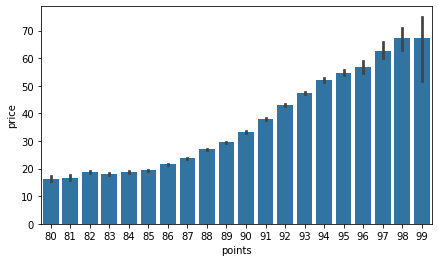

In [35]:
plt.figure(figsize=(7,4))
sns.barplot(data=winemag_clean, x="points", y="price", color='tab:blue')

In [36]:
print(f'Spearman correlation coefficient is: {winemag_clean["points"].corr(winemag_clean["price"], method="spearman"):.2f}')

Spearman correlation coefficient is: 0.57


### `country`

Observations:
* Most of the wines in the dataset comes from the United States (50016).
* 99.08% of wine in the dataset come from 16 countries.
* Some countries such as `China` only have one entry in the dataset where other such as France have thousands.
* On average, Germany has the most expensive wine, closely followed by France and Italy. Meanwhile, the cheapest wines are from India, Africa, and East Asia.
* The price of wine varies depending on the country/region.
* Kruskal-Wallis test indicates an association between `country` and `price`.
* Some countries/regions have higher rated wines. England has the highest rated wines followed by India. South America has the lower rated wines.
* ANOVA test indicates an association between `country` and `points`.

**Conclusion:** Country is associated with the price of wine as well as the wine customer ratings.

In [37]:
winemag_clean["country"].isnull().sum()

0

In [38]:
winemag_clean["country"].unique()

array(['Portugal', 'US', 'Spain', 'Italy', 'France', 'Germany',
       'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa',
       'New Zealand', 'Israel', 'Hungary', 'Greece', 'Romania', 'Mexico',
       'Canada', 'Turkey', 'Czech Republic', 'Slovenia', 'Luxembourg',
       'Croatia', 'Georgia', 'Uruguay', 'England', 'Lebanon', 'Serbia',
       'Brazil', 'Moldova', 'Morocco', 'Peru', 'India', 'Bulgaria',
       'Cyprus', 'Armenia', 'Switzerland', 'Bosnia and Herzegovina',
       'Ukraine', 'Slovakia', 'Macedonia', 'China'], dtype=object)

<AxesSubplot:xlabel='Count', ylabel='country'>

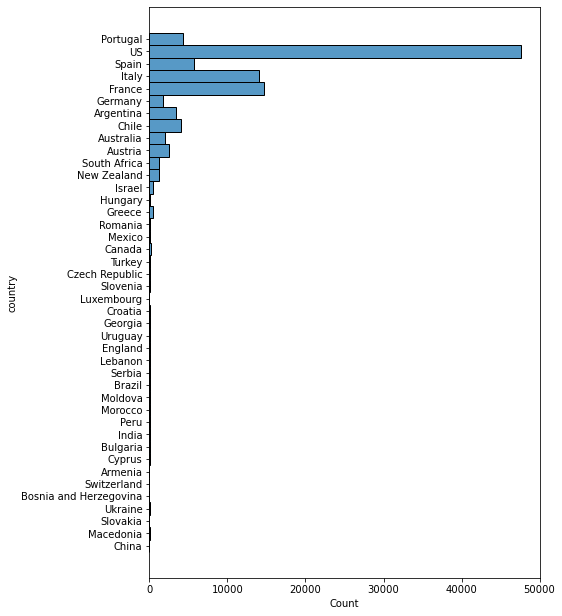

In [39]:
plt.figure(figsize=(7,10.5))
sns.histplot(data=winemag_clean, y="country", color='tab:blue')

Countries that produce the most kind of wine

In [40]:
winemag_clean["country"].value_counts().head(10)

US           47681
France       14694
Italy        14067
Spain         5732
Portugal      4330
Chile         4019
Argentina     3350
Austria       2466
Australia     1990
Germany       1782
Name: country, dtype: int64

Countries that produce the least kind of wine

In [41]:
winemag_clean["country"].value_counts().tail(10)

Macedonia                 11
Cyprus                    10
Serbia                     8
India                      8
Luxembourg                 5
Switzerland                4
Bosnia and Herzegovina     2
Armenia                    2
Slovakia                   1
China                      1
Name: country, dtype: int64

Some countries have significantly less wines than others. We map each country to a region and combines those with very low counts of wine.

In [42]:
winemag_clean["country_region"] = winemag_clean["country"].apply(map_country_to_region)

In [43]:
country_region_counts = winemag_clean["country_region"].value_counts()
country_region_counts

North America    47957
Europe           44237
South America     7525
Oceania           3206
Africa            1190
Middle East        553
South Asia           8
East Asia            1
Name: country_region, dtype: int64

In [44]:
threshold = winemag_clean.shape[0] * 0.1
# Group country regions with low (< 1% of all instances) counts as Others
winemag_clean["country_region2"] = winemag_clean.apply(lambda x: (x["country_region"] if country_region_counts[x["country_region"]] >= threshold else f"Other Regions"), axis=1)

<AxesSubplot:xlabel='country_region2', ylabel='Count'>

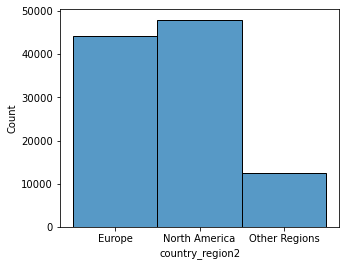

In [45]:
plt.figure(figsize=(5,4))
sns.histplot(data=winemag_clean, x="country_region2", color='tab:blue')

In [46]:
# Wine count per countries
wine_counts = winemag_clean["country"].value_counts()
# Calculate threshold for top 1% countries
threshold = winemag_clean.shape[0] * 0.01
# Group countries with low (< 1% of all instances) counts as Others
winemag_clean["country2"] = winemag_clean.apply(lambda x: (x["country"] if wine_counts[x["country"]] >= threshold else f"Other {x['country_region']}"), axis=1)

<AxesSubplot:xlabel='Count', ylabel='country2'>

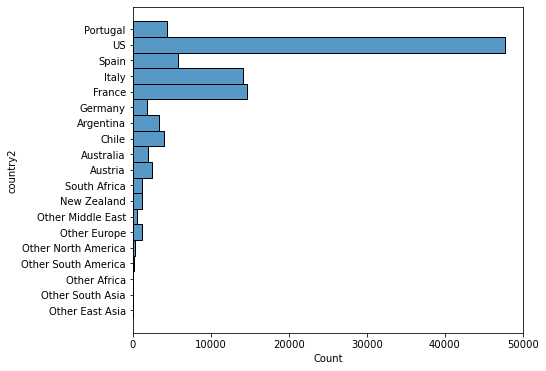

In [47]:
plt.figure(figsize=(7,6))
sns.histplot(data=winemag_clean, y="country2", color='tab:blue')

#### Relationship with `price`
We check the price range for each country

<AxesSubplot:xlabel='price', ylabel='country2'>

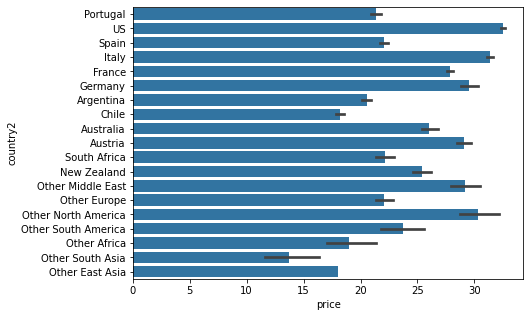

In [48]:
plt.figure(figsize=(7,5))
sns.barplot(data=winemag_clean, x="price", y="country2", color='tab:blue')

Average wine bottle price per region

In [49]:
print(winemag_clean[["country2", "price"]].groupby("country2", as_index=False).mean().sort_values(by="price", ascending=False).head(15).to_string(index=False))

           country2     price
                 US 32.521674
              Italy 31.367951
Other North America 30.336957
            Germany 29.558923
  Other Middle East 29.191682
            Austria 29.054745
             France 27.839732
          Australia 26.001010
        New Zealand 25.406250
Other South America 23.698718
       South Africa 22.134648
              Spain 22.098573
       Other Europe 22.088336
           Portugal 21.363282
          Argentina 20.527463


In [50]:
print(winemag_clean[["country_region2", "price"]].groupby("country_region2", as_index=False).mean().sort_values(by="price", ascending=False).to_string(index=False))

country_region2     price
  North America 32.509101
         Europe 27.569230
  Other Regions 21.692863


In [51]:
def variance_analysis(df, catg_col, num_col, method="anova"):
    # Perform Kruskal-Wallis test using grouped data
    grouped_data = [df[df[catg_col] == country][num_col] for country in df[catg_col].unique()]
    
    if method == "kruskal":
        statistic, p_value = kruskal(*grouped_data)
        name = "Kruskal-Wallis"
    elif method == "anova":
        # Perform ANOVA test
        statistic, p_value = f_oneway(*grouped_data)
        name = "ANOVA"
    else:
        raise Error(f"'{method}' not supported.")
    
    # Check the p-value for significance
    alpha = 0.05  # Set the significance level
    if p_value < alpha:
        print(f"{name} test indicates a significant difference among '{catg_col} in terms of '{num_col}'. (f-statistic: {statistic:.2f}, p-value: {p_value:.5f})")
    else:
        print(f"No significant difference among '{catg_col}' in terms of '{num_col}'. (f-statistic: {statistic:.2f}, p-value: {p_value:.5f})")

In [52]:
variance_analysis(winemag_clean, "country", "price", method="kruskal")
variance_analysis(winemag_clean, "country2", "price", method="kruskal")
variance_analysis(winemag_clean, "country_region", "price", method="kruskal")
variance_analysis(winemag_clean, "country_region2", "price", method="kruskal")

Kruskal-Wallis test indicates a significant difference among 'country in terms of 'price'. (f-statistic: 11810.78, p-value: 0.00000)
Kruskal-Wallis test indicates a significant difference among 'country2 in terms of 'price'. (f-statistic: 11404.22, p-value: 0.00000)
Kruskal-Wallis test indicates a significant difference among 'country_region in terms of 'price'. (f-statistic: 8335.26, p-value: 0.00000)
Kruskal-Wallis test indicates a significant difference among 'country_region2 in terms of 'price'. (f-statistic: 7549.16, p-value: 0.00000)


#### Relationship with `points`

<AxesSubplot:xlabel='points', ylabel='country2'>

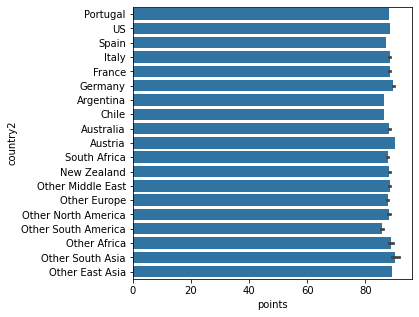

In [53]:
plt.figure(figsize=(5,5))
sns.barplot(data=winemag_clean, x="points", y="country2", color='tab:blue')

In [54]:
variance_analysis(winemag_clean, "country", "points")
variance_analysis(winemag_clean, "country2", "points")
variance_analysis(winemag_clean, "country_region", "points")
variance_analysis(winemag_clean, "country_region2", "points")

ANOVA test indicates a significant difference among 'country in terms of 'points'. (f-statistic: 152.68, p-value: 0.00000)
ANOVA test indicates a significant difference among 'country2 in terms of 'points'. (f-statistic: 329.25, p-value: 0.00000)
ANOVA test indicates a significant difference among 'country_region in terms of 'points'. (f-statistic: 459.83, p-value: 0.00000)
ANOVA test indicates a significant difference among 'country_region2 in terms of 'points'. (f-statistic: 1034.89, p-value: 0.00000)


Countries with highest rated wines

In [55]:
print(winemag_clean[["country2", "points"]].groupby("country2", as_index=False).mean().sort_values(by="points", ascending=False).head(15).to_string(index=False))

           country2    points
   Other South Asia 90.250000
            Austria 90.123277
            Germany 89.583614
    Other East Asia 89.000000
       Other Africa 88.708333
                 US 88.369413
  Other Middle East 88.311031
              Italy 88.303832
             France 88.296107
        New Zealand 88.241776
Other North America 88.228261
          Australia 88.214573
           Portugal 88.125173
       South Africa 87.688679
       Other Europe 87.640652


Regions with highest rated wines

In [56]:
print(winemag_clean[["country_region2", "points"]].groupby("country_region2", as_index=False).mean().sort_values(by="points", ascending=False).head(15).to_string(index=False))

country_region2    points
  North America 88.368601
         Europe 88.248457
  Other Regions 87.054714


Wine from different countries/region have on average the same rating. This would suggest that country/region doesn't have a significant influence on the rating (`points`).

### `title` (`name`/`brand`)

The name of the winery is included in every `title`. We could use the winery as `brand` name.

In [57]:
winemag_clean.apply(lambda x: re.search(re.escape(x["winery"]), x["title"]) is None, axis=1).sum()

0

The wine name is not much needed for this study. It's characteristics are more important.

### `description`

In [58]:
winemag_clean["description"].isnull().sum()

0

In [59]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

def preprocess_text(text):
    # Remove numerical tokens
    text = re.sub(r'\b\d+\b', '', text)
    return text

def custom_tokenizer(text):
    # Custom tokenizer to preprocess text and extract tokens
    text = preprocess_text(text)
    return text.split()

def encode_texts(data):
    # Custom stop words
    descriptions = data.apply(lambda x: re.sub(f"{re.escape(x['variety'])}|{x['winery']}", "", x["description"]), axis=1)
    # Apply TF-IDF vectorization with binary encoding
    tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=text.ENGLISH_STOP_WORDS, binary=True, max_features=10000)
    encoded_documents = tfidf_vectorizer.fit_transform(descriptions)
    return encoded_documents

In [60]:
%%time
encoded_docs = encode_texts(winemag_clean)

CPU times: total: 8.92 s
Wall time: 9.12 s


In [61]:
encoded_docs

<104677x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2349313 stored elements in Compressed Sparse Row format>

In [62]:
%%time
svd = TruncatedSVD(n_components=1000)
encoded_docs_reduced = svd.fit_transform(encoded_docs)

CPU times: total: 2min 33s
Wall time: 51.1 s


In [63]:
explained_variance_ratio = svd.explained_variance_ratio_
print("Explained variance ratio:", sum(explained_variance_ratio))

Explained variance ratio: 0.5275333815225469


<AxesSubplot:>

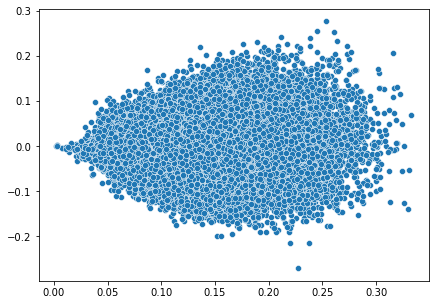

In [64]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=encoded_docs_reduced[:, 0], y=encoded_docs_reduced[:, 10])

In [ ]:
for n_components in range(2, 10000):
    svd = TruncatedSVD(n_components=n_components)
    _ = svd.fit_transform(encoded_docs)
    explained_variance_ratio = svd.explained_variance_ratio_
    if (n_components < 1000 and n_components % 100 == 0) or n_components % 1000 == 0 or sum(explained_variance_ratio) >= 0.7:
        print(f"With n_components = {n_components}, Explained variance ratio:", sum(explained_variance_ratio))

With n_components = 100, Explained variance ratio: 0.14599125832882973
With n_components = 200, Explained variance ratio: 0.22608424980321562
With n_components = 300, Explained variance ratio: 0.28726843216018205


In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=encoded_docs_reduced[:, 0], y=encoded_docs_reduced[:, 1], hue=clusters)

In [59]:
def preprocess_and_encode(documents, method='tfidf'):
    # Load fruit and term lists
    fruits = pd.read_csv('fruits.csv')['Fruit'].str.lower().tolist()
    terms = pd.read_csv('terms.csv')['Term'].str.lower().tolist()

    # Combine fruit and term lists
    valid_words = fruits + terms

    # Filter documents based on valid words
    filtered_documents = []
    for doc in documents:
        filtered_words = [word for word in doc.split() if word.lower() in valid_words]
        filtered_documents.append(' '.join(filtered_words))

    # Encode documents using TF-IDF or other specified method
    if method == 'tfidf':
        vectorizer = TfidfVectorizer()
        encoded_docs = vectorizer.fit_transform(filtered_documents)
    else:
        # Other encoding method
        pass

    return encoded_docs

In [60]:
wine_descriptions = winemag_clean['description'].tolist()

In [61]:
tfidf_matrix = preprocess_and_encode(wine_descriptions)

Reduce dimensions and visualize

In [62]:
%%time
svd = TruncatedSVD(n_components=2)
tfidf_reduced = svd.fit_transform(tfidf_matrix)

CPU times: total: 1.12 s
Wall time: 179 ms


<AxesSubplot:>

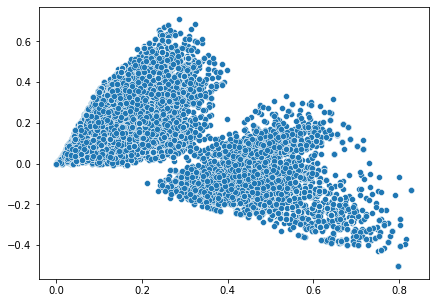

In [63]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=tfidf_reduced[:, 0], y=tfidf_reduced[:, 1])

In [65]:
%%time
tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate='auto')
tfidf_reduced_tnse = tsne.fit_transform(tfidf_matrix)

CPU times: total: 1h 16min 48s
Wall time: 11min 17s


<AxesSubplot:>

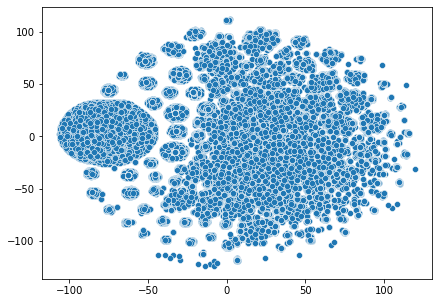

In [66]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=tfidf_reduced_tnse[:, 0], y=tfidf_reduced_tnse[:, 1])

Cluster the descriptions

In [69]:
from sklearn.cluster import DBSCAN

In [70]:
%%time
dbscan = DBSCAN(eps=1.0, min_samples=5)
dbscan_cluster_labels = dbscan.fit_predict(tfidf_matrix)
np.unique(dbscan_cluster_labels)

MemoryError: Unable to allocate 1.00 GiB for an array with shape (1282, 104677) and data type float64

In [71]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=tfidf_reduced[:, 0], y=tfidf_reduced[:, 1], hue=dbscan_cluster_labels)

NameError: name 'dbscan_cluster_labels' is not defined

<Figure size 504x360 with 0 Axes>

#### KMeans

In [82]:
from sklearn.metrics import silhouette_score

In [79]:
# Perform clustering using K-Means with 5 clusters
kmeans = KMeans(n_clusters=5)
kmeans_cluster_labels = kmeans.fit_predict(tfidf_matrix)

In [83]:
for n_clusters in range(2, 12):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is {silhouette_avg:.4f}")

For n_clusters = 2, the average silhouette_score is 0.0876
For n_clusters = 3, the average silhouette_score is 0.1004
For n_clusters = 4, the average silhouette_score is 0.1076
For n_clusters = 5, the average silhouette_score is 0.1174
For n_clusters = 6, the average silhouette_score is 0.1307
For n_clusters = 7, the average silhouette_score is 0.1347
For n_clusters = 8, the average silhouette_score is 0.1447
For n_clusters = 9, the average silhouette_score is 0.1539
For n_clusters = 10, the average silhouette_score is 0.1552
For n_clusters = 11, the average silhouette_score is 0.1676


<AxesSubplot:>

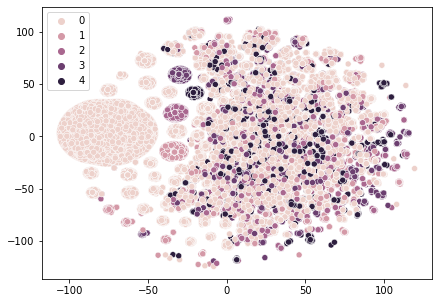

In [80]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=tfidf_reduced_tnse[:, 0], y=tfidf_reduced_tnse[:, 1], hue=kmeans_cluster_labels)

In [68]:
# Perform clustering using AgglomerativeClustering (no pre-specified number of clusters)
agg_clustering = AgglomerativeClustering()
agg_cluster_labels = agg_clustering.fit_predict(tfidf_matrix)

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

<AxesSubplot:>

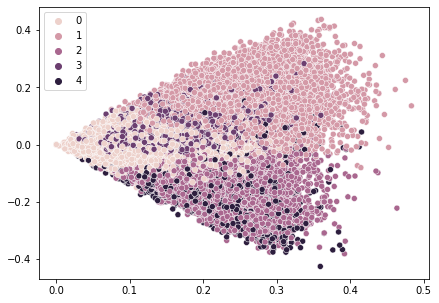

In [251]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=tfidf_reduced[:, 0], y=tfidf_reduced[:, 1], hue=cluster_labels)

In [252]:
# Retrieve top words for each cluster
top_terms_per_cluster = get_top_terms_per_cluster(tfidf_matrix, vectorizer, kmeans)
# Print top words for each cluster
for cluster_num, top_terms in top_terms_per_cluster.items():
    print(f"Cluster {cluster_num} top terms: {', '.join(top_terms)}")

Cluster 0 top terms: aeration, accord, aceri, acorns, absense, accomplished, admittance, accessibility, adolph, adaptable
Cluster 1 top terms: aeration, aaron, acetic, add, acetone, adamant, abruzzo, accesses, adaptable, adolph
Cluster 2 top terms: ability, absense, acrid, abeille, actors, aberrant, adolph, accord, accomplished, adhesive
Cluster 3 top terms: abbey, acrid, absorbed, aerate, acridness, accord, acidity, accomplished, aaron, acrobat
Cluster 4 top terms: abrazo, addition, acidmineral, abnormal, accumulate, ability, action, adolph, advertisement, accord


### `variety`

Observations:
* There are 692 unique wine varieties.
* Soem wine varieties are very rare in the dataset.
* 300 wine varieties make up 99% of all varieties in the dataset.
* The most common wine variety are Pinot Noir, Chardonnay, Cabernet Sauvignon, and Red Blend.
* The US produces the most variety of wine, followed by Italy, France and Spain.
* On average, Nebbiolo is the most expensive wine variety, followed by Cabernet Sauvignon, Bordeaux-style Red Blend, and Pinot Noir. Meanwhile, Trajadura is the cheapest variety.
* The price of wine varies from a variety to another.
* Nebbiolo is the highest rated wine followed by Riesling, Pinot Noir, Syrah, and Rhône-style Red Blend.

**Conclusion:** Wine `variety` influences the `price` and can also be associated with `points`.

In [57]:
winemag_clean["variety"].unique().shape[0]

686

In [58]:
winemag_clean["variety"].value_counts().head(300).sum() / winemag_clean.shape[0]

0.9904936929308868

In [59]:
winemag_clean["variety"].value_counts().head(25)

Pinot Noir                  10903
Chardonnay                   9728
Cabernet Sauvignon           7326
Red Blend                    7276
Bordeaux-style Red Blend     4385
Sauvignon Blanc              4384
Riesling                     4366
Syrah                        3577
Rosé                         2934
Merlot                       2767
Zinfandel                    2512
Malbec                       2270
White Blend                  1964
Portuguese Red               1947
Sangiovese                   1885
Nebbiolo                     1646
Tempranillo                  1556
Sparkling Blend              1550
Pinot Gris                   1243
Rhône-style Red Blend        1236
Cabernet Franc               1135
Grüner Veltliner             1002
Pinot Grigio                  932
Portuguese White              903
Viognier                      887
Name: variety, dtype: int64

In [60]:
print(winemag_clean[["country", "variety"]].drop_duplicates(subset=["country", "variety"]).groupby("country", as_index=False).count().sort_values(by="variety", ascending=False).head(10).to_string())

         country  variety
39            US      254
21         Italy      184
14        France      142
36         Spain      124
30      Portugal       85
0      Argentina       66
2      Australia       66
8          Chile       62
3        Austria       54
35  South Africa       52


Some varieties of wine are very rare in the dataset. We combine them as `Other Varieties`.

In [61]:
variety_counts = winemag_clean["variety"].value_counts()
threshold = winemag_clean.shape[0] * 0.01

In [62]:
winemag_clean["variety2"] = winemag_clean.apply(lambda x: (x["variety"] if variety_counts[x["variety"]] >= threshold else f"Other Varieties"), axis=1)

<AxesSubplot:xlabel='Count', ylabel='variety2'>

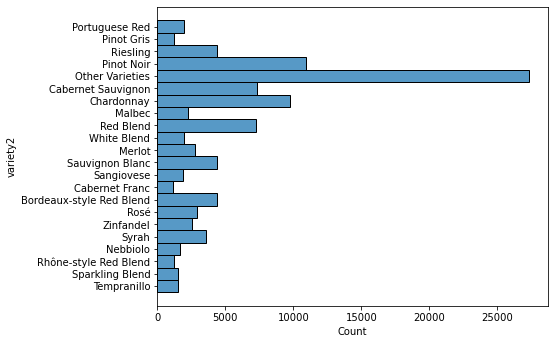

In [63]:
plt.figure(figsize=(7,5.5))
sns.histplot(data=winemag_clean, y="variety2", color='tab:blue')

#### Realtionship with `price`

<AxesSubplot:xlabel='price', ylabel='variety2'>

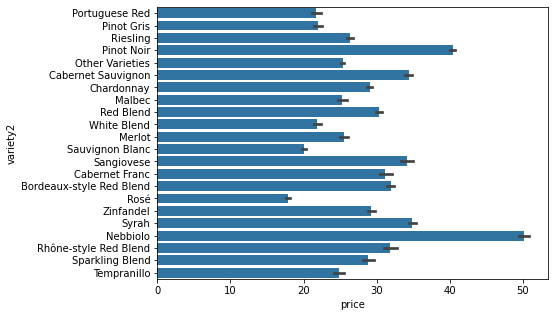

In [64]:
plt.figure(figsize=(7,5))
sns.barplot(data=winemag_clean, x="price", y="variety2", color='tab:blue')

#### Relationship wtih `points`

Highest rated wine varieties

<AxesSubplot:xlabel='points', ylabel='variety2'>

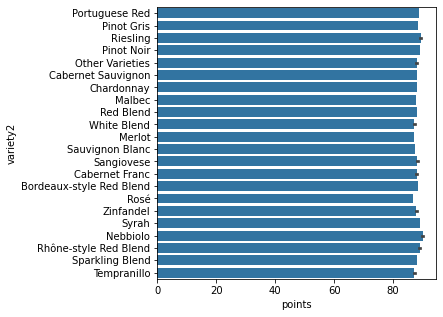

In [65]:
plt.figure(figsize=(5,5))
sns.barplot(data=winemag_clean, x="points", y="variety2", color='tab:blue')

In [66]:
variance_analysis(winemag_clean, "variety", "points")
variance_analysis(winemag_clean, "variety2", "points")

ANOVA test indicates a significant difference among 'variety in terms of 'points'. (f-statistic: 15.56, p-value: 0.00000)
ANOVA test indicates a significant difference among 'variety2 in terms of 'points'. (f-statistic: 258.98, p-value: 0.00000)


### `winery`

Observations:
* There are 15843 wineries in the dataset
* The US has the highest number of wineries (5368), followed by France, Italy, Spain, then Argentina.
* On average, some wineries produce higher rated wines than others.
* On average, Lynmar (US) wines have the highest ratings, this is followed by Williams Selyem (US), Gary Farrell (US), Testarossa (US), and Louis Latour (France).
* On average, certain wineries produce more expensive wines than others. Louis Latour (France) produces significantly more expensive wine than other wineries.

**Conclusion:** `winery` is associated with `price` and `points`.

In [67]:
winemag_clean["winery"].unique().shape[0]

15532

In [68]:
winemag_clean["winery"].value_counts().head(20)

Wines & Winemakers       197
Testarossa               196
DFJ Vinhos               194
Williams Selyem          182
Chateau Ste. Michelle    170
Columbia Crest           145
Concha y Toro            140
Gary Farrell             118
Kendall-Jackson          114
Siduri                   113
Georges Duboeuf          112
Trapiche                 106
Lynmar                   103
Undurraga                103
Santa Ema                101
Robert Mondavi            99
Maryhill                  97
Foxen                     96
Cameron Hughes            94
Fess Parker               94
Name: winery, dtype: int64

Which country has the most wineries?

<AxesSubplot:xlabel='num_wineries', ylabel='country2'>

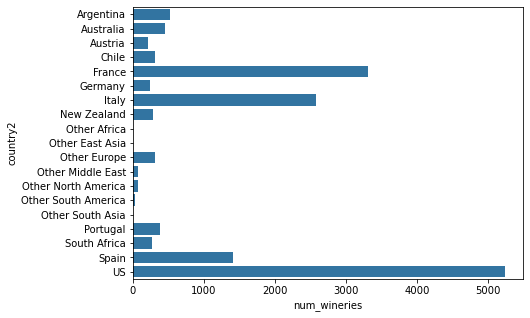

In [69]:
plt.figure(figsize=(7,5))
sns.barplot(
    data=winemag_clean[["country2", "winery"]].drop_duplicates(subset=["country2", "winery"]).rename(columns={"winery": "num_wineries"}).groupby("country2", as_index=False).count(), 
    y="country2", x="num_wineries", color='tab:blue'
)

In [70]:
winery_counts = winemag_clean["winery"].value_counts()

In [71]:
print(f'{winery_counts[(winery_counts < winery_counts.shape[0]*0.01)].shape[0] / winery_counts.shape[0] * 100:.2f} wineries produce less than 1% of all the different wine bottles')
print(f'{winery_counts[(winery_counts >=100)].shape[0] / winery_counts.shape[0] * 100:.2f} wineries produce 100 different wine bottles or more')
print(f'{winery_counts[(winery_counts >=50) & (winery_counts < 100)].shape[0] / winery_counts.shape[0] * 100:.2f} wineries produce between 50 and 100 different wine bottles')
print(f'{winery_counts[(winery_counts >=10) & (winery_counts < 50)].shape[0] / winery_counts.shape[0] * 100:.2f} wineries produce between 10 and 50 different wine bottles')
print(f'{winery_counts[(winery_counts < 10)].shape[0] / winery_counts.shape[0] * 100:.2f} wineries produce less than 10 different wine bottles')

99.97 wineries produce less than 1% of all the different wine bottles
0.10 wineries produce 100 different wine bottles or more
1.13 wineries produce between 50 and 100 different wine bottles
17.49 wineries produce between 10 and 50 different wine bottles
81.28 wineries produce less than 10 different wine bottles


Most of the wineries in the dataset produce less than 10 unique wine bottles. Only 6 wineries produce at least 1% of all the different wine bottles. In order to group the wineries with a low count of unique wine bottles, we would have to raise the threshold. Since most wineries produces less than 10 unique wine bottles, we can set the threshold to 10.

In [72]:
winemag_clean["winery2"] = winemag_clean.apply(lambda x: (x["winery"] if winery_counts[x["winery"]] >= 10 else f"Other Wineries"), axis=1)
# Winery3 is only for visualization purpose
winemag_clean["winery3"] = winemag_clean.apply(lambda x: (x["winery"] if winery_counts[x["winery"]] >= 100 else f"Other Wineries"), axis=1)

#### Relationship with `points`
Which winery produces the highest rated wines

<AxesSubplot:xlabel='points', ylabel='winery3'>

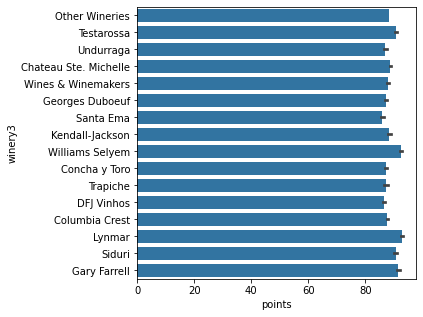

In [73]:
plt.figure(figsize=(5,5))
sns.barplot(data=winemag_clean, x="points", y="winery3", color='tab:blue')

In [74]:
variance_analysis(winemag_clean, "winery", "points")
variance_analysis(winemag_clean, "winery2", "points")

ANOVA test indicates a significant difference among 'winery in terms of 'points'. (f-statistic: 5.82, p-value: 0.00000)
ANOVA test indicates a significant difference among 'winery2 in terms of 'points'. (f-statistic: 13.39, p-value: 0.00000)


#### Relationship with `price`

<AxesSubplot:xlabel='price', ylabel='winery3'>

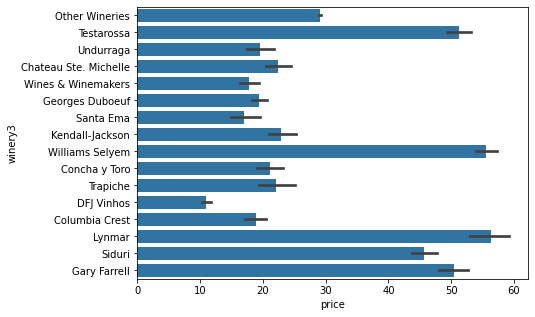

In [75]:
plt.figure(figsize=(7,5))
sns.barplot(data=winemag_clean, x="price", y="winery3", color='tab:blue')

In [76]:
variance_analysis(winemag_clean, "winery", "price")
variance_analysis(winemag_clean, "winery2", "price")

ANOVA test indicates a significant difference among 'winery in terms of 'price'. (f-statistic: 8.24, p-value: 0.00000)
ANOVA test indicates a significant difference among 'winery2 in terms of 'price'. (f-statistic: 17.30, p-value: 0.00000)


## Dimension Reduction

In this section, we selected the features associated with `points` and reduce the dimensions to 2 using PCA. We then visualize the data to oberve any trends.

In [77]:
features = ["country", "price", "variety", "winery2"]
X = winemag_clean[features]
X_encoded = pd.get_dummies(X, columns=["country", "variety", "winery2"])

In [78]:
scaler = StandardScaler()
X_encoded = X_encoded.copy()
X_encoded["price"] = scaler.fit_transform(X_encoded["price"].values.reshape(-1, 1))

In [79]:
pca = PCA(n_components=2)

In [80]:
%%time
X_embed = pca.fit_transform(X_encoded)

CPU times: total: 33.7 s
Wall time: 9.63 s


In [81]:
print("Explained variance by each component:", pca.explained_variance_ratio_)

Explained variance by each component: [0.28721512 0.09103565]


<AxesSubplot:>

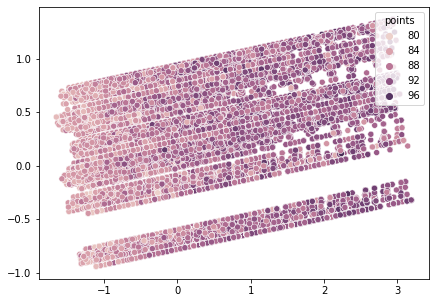

In [82]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=X_embed[:, 0], y=X_embed[:, 1], hue=winemag_clean["points"])

<AxesSubplot:ylabel='points'>

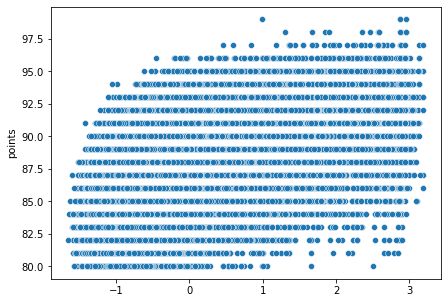

In [85]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=X_embed[:, 0], y=winemag_clean["points"])

## Data Preprocessing

In [83]:
def preprocess_data(data):
    # Select relevant columns
    winemag_columns = ["id", "country", "points", "price", "variety", "winery", "title"]
    winemag_clean = data[winemag_columns].copy()
    
    # Remove entries with no price or country
    winemag_clean = winemag_clean[(~winemag_clean["country"].isnull()) & (~winemag_clean["price"].isnull())]
    winemag_clean = winemag_clean[~winemag_clean["variety"].isnull()]
    
    # Handle duplicates
    winemag_clean = winemag_clean.drop("id", axis=1).drop_duplicates()
    winemag_clean = remove_duplicated_titles(winemag_clean)
    
    # Categorize price
    winemag_clean["price_group"] = winemag_clean["price"].apply(categorize_wine_price)
    
    # Add country_region
    
    winemag_clean["country_region"] = winemag_clean["country"].apply(map_country_to_region)
    # Wine count per countries
    wine_counts = winemag_clean["country"].value_counts()
    
    # Calculate threshold for top 1% countries
    threshold = winemag_clean.shape[0] * 0.01
    
    # Group countries with low (< 1% of all instances) counts as Others
    winemag_clean["country2"] = winemag_clean.apply(lambda x: (x["country"] if wine_counts[x["country"]] >= threshold else f"Other {x['country_region']}"), axis=1)
    
    # Group varieties with low counts
    variety_counts = winemag_clean["variety"].value_counts()
    threshold = winemag_clean.shape[0] * 0.01
    winemag_clean["variety2"] = winemag_clean.apply(lambda x: (x["variety"] if variety_counts[x["variety"]] >= threshold else f"Other Varieties"), axis=1)
    
    # Group wineries with low counts
    winery_counts = winemag_clean["winery"].value_counts()
    winemag_clean["winery2"] = winemag_clean.apply(lambda x: (x["winery"] if winery_counts[x["winery"]] >= 10 else f"Other Wineries"), axis=1)
    
    return winemag_clean